In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import mlflow.xgboost

In [48]:
df = pd.read_csv('survey_results.csv')

In [49]:
df.head(2)

,respondent_id,age,gender,zone,occupation,income_levels,consume_frequency(weekly),current_brand,preferable_consumption_size,awareness_of_other_brands,reasons_for_choosing_brands,flavor_preference,purchase_channel,packaging_preference,health_concerns,typical_consumption_situations,price_range
0,R00001,30,M,Urban,Working Professional,<10L,3-4 times,Newcomer,Medium (500 ml),0 to 1,Price,Traditional,Online,Simple,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",100-150
1,R00002,46,F,Metro,Working Professional,> 35L,5-7 times,Established,Medium (500 ml),2 to 4,Quality,Exotic,Retail Store,Premium,Medium (Moderately health-conscious),Social (eg. Parties),200-250


In [50]:
# Check for duplicates based on respondent_id
duplicate_count = df.duplicated(subset=['respondent_id']).sum()

# Remove duplicates, keep the first occurrence
df_clean = df.drop_duplicates(subset=['respondent_id'])

# Confirm removal
rows_removed = df.shape[0] - df_clean.shape[0]

duplicate_count, rows_removed, df_clean.shape[0]

(np.int64(10), 10, 30000)

In [51]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

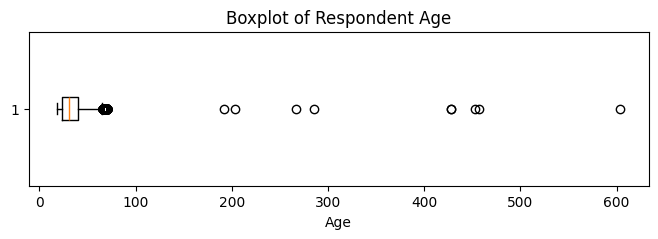

count    30000.000000
mean        33.048167
std         13.438904
min         18.000000
25%         23.000000
50%         31.000000
75%         40.000000
max        604.000000
Name: age, dtype: float64

In [52]:
# Describe the age column
age_desc = df_clean['age'].describe()

# Visualize age distribution using a boxplot
plt.figure(figsize=(8, 2))
plt.boxplot(df_clean['age'], vert=False)
plt.title('Boxplot of Respondent Age')
plt.xlabel('Age')
plt.show()

age_desc

In [53]:
# Find all ages below 18 and above 100
outliers = df_clean[(df_clean['age'] < 18) | (df_clean['age'] > 100)][['respondent_id', 'age']]
outliers_count = outliers.shape[0]
outliers

,respondent_id,age
3099,R03098,453
6262,R06260,428
12403,R12398,604
22549,R22542,457
22918,R22911,267
24958,R24950,285
24960,R24952,192
25105,R25096,203
28770,R28761,428


In [54]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = round(Q1 - 1.5 * IQR)
upper_bound = round(Q3 + 1.5 * IQR)

lower_bound, upper_bound

(-2, 66)

In [55]:
age_mean = df['age'].mean()
age_std = df['age'].std()

df['z_score_age'] = (df['age'] - age_mean) / age_std

threshold = 3

new_df = df[np.abs(df['z_score_age']) < threshold].copy()
new_df.drop('z_score_age', axis='columns', inplace=True)

In [56]:
new_df.shape

(29991, 17)

In [57]:
new_df.describe()

,age
count,29991.000000
mean,32.947484
std,11.906077
min,18.000000
25%,23.000000
50%,31.000000
75%,40.000000
max,70.000000


In [58]:
new_df['consume_frequency(weekly)'].isnull().sum()

np.int64(8)

In [59]:
new_df['consume_frequency(weekly)'].mode()

0    3-4 times
Name: consume_frequency(weekly), dtype: object

In [60]:
new_df['consume_frequency(weekly)'].fillna(new_df['consume_frequency(weekly)'].mode(), inplace=True)

C:\Users\serhii_kravchenko4\AppData\Local\Temp\ipykernel_17584\2650395704.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['consume_frequency(weekly)'].fillna(new_df['consume_frequency(weekly)'].mode(), inplace=True)


In [61]:
new_df["income_levels"].fillna("Not Reported", inplace=True)

C:\Users\serhii_kravchenko4\AppData\Local\Temp\ipykernel_17584\3510089764.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df["income_levels"].fillna("Not Reported", inplace=True)


In [62]:
new_df['zone'] = new_df['zone'].str.lower().str.strip()

In [63]:
new_df['current_brand'].unique()

array(['Newcomer', 'Established', 'newcomer', 'Establishd'], dtype=object)

In [64]:
corrections = {
    "newcomer": "Newcomer",
    "Establishd": "Established"
}
new_df['current_brand'].replace(corrections, inplace=True)

C:\Users\serhii_kravchenko4\AppData\Local\Temp\ipykernel_17584\2740840892.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['current_brand'].replace(corrections, inplace=True)


In [65]:
new_df['current_brand'] = new_df['current_brand'].str.lower().str.strip()
new_df['current_brand'].unique()

array(['newcomer', 'established'], dtype=object)

In [66]:
# Common misspellings might include: 'Merto', 'Metor', etc.
possible_misspellings = ['merto', 'metor', 'metroo', 'metra', 'metre']

# Lowercase comparison for robust matching
misspelled_rows = df[df['zone'].str.lower().isin(possible_misspellings)]

misspelled_count = misspelled_rows.shape[0]
misspelled_count


4

In [67]:
bins = [18, 26, 36, 46, 56, 71, float('inf')]
labels = ['18-25', '26-35', '36-45', '46-55', '56-70', '70+']
new_df['age_group'] = pd.cut(new_df['age'], bins=bins, labels=labels, right=False)

In [68]:
new_df.drop('age', axis='columns', inplace=True)

In [69]:
consume_map = {
    "0-2 times": 1,
    "3-4 times": 2,
    "5-7 times": 3
}
new_df['consume_frequency(weekly)'].replace(consume_map,inplace=True)


C:\Users\serhii_kravchenko4\AppData\Local\Temp\ipykernel_17584\2731429754.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['consume_frequency(weekly)'].replace(consume_map,inplace=True)
C:\Users\serhii_kravchenko4\AppData\Local\Temp\ipykernel_17584\2731429754.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_d

In [70]:
awareness_map = {
    "0 to 1": 1,
    "2 to 4":2,
    "above 4":3
}
new_df['awareness_of_other_brands'].replace(awareness_map,inplace=True)

C:\Users\serhii_kravchenko4\AppData\Local\Temp\ipykernel_17584\3576536698.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df['awareness_of_other_brands'].replace(awareness_map,inplace=True)
C:\Users\serhii_kravchenko4\AppData\Local\Temp\ipykernel_17584\3576536698.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent

In [71]:
new_df['cf_ab_score'] = round(new_df['consume_frequency(weekly)']/ (new_df['awareness_of_other_brands']+new_df['consume_frequency(weekly)']), 2)

In [72]:
location_mapping = {
    "urban": 3,
    "metro": 4,
    "rural": 1,
    "semi-urban": 2
}

income_mapping = {
    "<10L": 1,
    "10L - 15L": 2,
    "16L - 25L": 3,
    "26L - 35L": 4,
    "> 35L": 5,
    "Not Reported": 0
}

In [73]:
# Apply the location mapping to the 'zone' column
new_df['zone'] = new_df['zone'].replace(location_mapping)

# Apply the income mapping to the 'income_levels' column
new_df['income_levels'] = new_df['income_levels'].replace(income_mapping)

# Now perform the multiplication
new_df['zas_score'] = new_df['zone'] * new_df['income_levels']

C:\Users\serhii_kravchenko4\AppData\Local\Temp\ipykernel_17584\3036244447.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df['income_levels'] = new_df['income_levels'].replace(income_mapping)


In [74]:
def bsi_func(df: pd.DataFrame):
    if df['current_brand'].lower() != "established":
        if df['reasons_for_choosing_brands'] in ["Price", "Quality"]:
            return 1

    return 0

In [75]:
new_df['bsi'] = new_df.apply(bsi_func, axis='columns')

In [76]:
new_df.head(2)

,respondent_id,gender,zone,occupation,income_levels,consume_frequency(weekly),current_brand,preferable_consumption_size,awareness_of_other_brands,reasons_for_choosing_brands,flavor_preference,purchase_channel,packaging_preference,health_concerns,typical_consumption_situations,price_range,age_group,cf_ab_score,zas_score,bsi
0,R00001,M,3,Working Professional,1,2.0,newcomer,Medium (500 ml),1,Price,Traditional,Online,Simple,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",100-150,26-35,0.67,3,1
1,R00002,F,4,Working Professional,5,3.0,established,Medium (500 ml),2,Quality,Exotic,Retail Store,Premium,Medium (Moderately health-conscious),Social (eg. Parties),200-250,46-55,0.60,20,0


In [77]:
# Define the outlier conditions
outliers = (
    ((new_df['occupation'] == 'Student') & (new_df['age_group'] == '56-70')) |
    ((new_df['occupation'] == 'Retired') & (new_df['age_group'].isin(['18-25', '26-35', '36-45'])))
)

# Remove outliers
new_df = new_df[~outliers]

# Count remaining rows
remaining_rows = new_df.shape[0]

print(f"Rows remaining after removing logical outliers: {remaining_rows}")


Rows remaining after removing logical outliers: 29956


In [78]:
new_df['cf_ab_score'].max()

np.float64(0.75)

In [79]:
new_df['zas_score'].nunique()

19

In [80]:
new_df[new_df['bsi']==0].shape

(20796, 20)

In [81]:
new_df.head(1)

,respondent_id,gender,zone,occupation,income_levels,consume_frequency(weekly),current_brand,preferable_consumption_size,awareness_of_other_brands,reasons_for_choosing_brands,flavor_preference,purchase_channel,packaging_preference,health_concerns,typical_consumption_situations,price_range,age_group,cf_ab_score,zas_score,bsi
0,R00001,M,3,Working Professional,1,2.0,newcomer,Medium (500 ml),1,Price,Traditional,Online,Simple,Medium (Moderately health-conscious),"Active (eg. Sports, gym)",100-150,26-35,0.67,3,1


In [82]:
new_df['price_range'].unique()

array(['100-150', '200-250', '150-200', '50-100'], dtype=object)

In [83]:
new_df.to_csv("survey_results_v2.csv", index=False)

In [84]:
new_df.isna().sum()

respondent_id                      0
gender                             0
zone                               0
occupation                         0
income_levels                      0
consume_frequency(weekly)          8
current_brand                      0
preferable_consumption_size        0
awareness_of_other_brands          0
reasons_for_choosing_brands        0
flavor_preference                  0
purchase_channel                  10
packaging_preference               0
health_concerns                    0
typical_consumption_situations     0
price_range                        0
age_group                          0
cf_ab_score                        8
zas_score                          0
bsi                                0
dtype: int64

In [89]:
from sklearn.compose        import ColumnTransformer
from sklearn.impute         import SimpleImputer
from sklearn.preprocessing  import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline       import Pipeline
from sklearn.ensemble       import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 0) Define X and y properly — no Ellipsis!
drop_cols = ['respondent_id', 'price_range', 'age_group', 'income_levels']
X = new_df.drop(columns=drop_cols)
y = new_df['price_range']

# 1) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# 2) Identify categorical vs numeric
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# 3) Build transformers (forcing all cats to str to avoid mixed‐type errors)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',   StandardScaler())
])
categorical_transformer = Pipeline([
    ('to_str',   FunctionTransformer(lambda df: df.astype(str), validate=False)),
    ('imputer',  SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',   OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer,    num_cols),
    ('cat', categorical_transformer, cat_cols),
], remainder='drop')

# 4) Full pipeline and fit
model = Pipeline([
    ('prep', preprocessor),
    ('clf',  RandomForestClassifier(random_state=42, n_jobs=-1))
])

model.fit(X_train, y_train)
print("Test accuracy:", model.score(X_test, y_test))


Test accuracy: 0.84029910535452


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

classifiers = {
    'LogReg': LogisticRegression(max_iter=500),
    'SVM':   SVC(),
    'GB':    GradientBoostingClassifier(),
    'RF':    RandomForestClassifier(random_state=42)
}

results = {}
for name, clf in classifiers.items():
    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results[name] = accuracy_score(y_test, y_pred)

# summary table
pd.Series(results, name='Accuracy').sort_values(ascending=False)


SVM       0.851382
RF        0.840299
GB        0.819469
LogReg    0.807451
Name: Accuracy, dtype: float64

In [91]:
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import accuracy_score, classification_report
from xgboost               import XGBClassifier

# 1) Label-encode the string targets
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# 2) Build the full Pipeline (reuse your preprocessor defined earlier)
xgb_pipe = Pipeline([
    ('prep', preprocessor),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=42
    ))
])

# 3) Fit & predict on raw X_train / X_test
xgb_pipe.fit(X_train, y_train_enc)
y_pred_enc = xgb_pipe.predict(X_test)

# 4) Evaluate
acc = accuracy_score(y_test_enc, y_pred_enc)
print(f"XGBoost Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(
    y_test_enc,
    y_pred_enc,
    target_names=le.classes_
))


C:\Users\serhii_kravchenko4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [22:23:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8687

Classification Report:
              precision    recall  f1-score   support

     100-150       0.86      0.85      0.86      1930
     150-200       0.80      0.85      0.83      2223
     200-250       0.93      0.90      0.91      2430
      50-100       0.90      0.89      0.89       906

    accuracy                           0.87      7489
   macro avg       0.87      0.87      0.87      7489
weighted avg       0.87      0.87      0.87      7489



In [92]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost

from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import accuracy_score, classification_report
from sklearn.linear_model  import LogisticRegression
from sklearn.svm           import SVC
from sklearn.ensemble      import GradientBoostingClassifier, RandomForestClassifier
from xgboost               import XGBClassifier

# 0) point MLflow at your server / local files
# mlflow.set_tracking_uri("http://localhost:5000") # Comment out or remove this line
mlflow.set_experiment("Model_Comparison")

# 1) label-encode your y once
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# 2) define all your “raw” classifiers
classifiers = {
    "LogReg":   LogisticRegression(max_iter=500),
    "SVM":      SVC(),
    "GB":       GradientBoostingClassifier(),
    "RF":       RandomForestClassifier(random_state=42),
    "XGBoost":  XGBClassifier(
                    objective="multi:softprob",
                    use_label_encoder=False,
                    eval_metric="mlogloss",
                    n_jobs=-1,
                    random_state=42
                )
}

# 3) loop through, train, evaluate, and send everything to MLflow
for name, clf in classifiers.items():
    with mlflow.start_run(run_name=name):
        # build a pipeline on the fly
        pipe = Pipeline([
            ("prep", preprocessor),  # your existing ColumnTransformer
            ("clf",  clf)
        ])

        # train & predict
        pipe.fit(X_train, y_train_enc)
        y_pred = pipe.predict(X_test)

        # compute metrics
        acc    = accuracy_score(y_test_enc, y_pred)
        report = classification_report(
            y_test_enc,
            y_pred,
            output_dict=True,
            target_names=le.classes_
        )

        # log params + metrics
        mlflow.log_param("model_name", name)
        mlflow.log_metric("accuracy", acc)
        # log per-class recall
        for cls in le.classes_:
            mlflow.log_metric(f"recall_{cls}", report[cls]["recall"])
        # log macro-avg F1
        mlflow.log_metric("f1_macro", report["macro avg"]["f1-score"])

        # log the model artifact
        if name == "XGBoost":
            # log just the XGBoost estimator
            mlflow.xgboost.log_model(
                pipe.named_steps["clf"],
                artifact_path="model"
            )
        else:
            # log the full pipeline for sklearn models
            mlflow.sklearn.log_model(
                pipe,
                artifact_path="model"
            )

        print(f"> Logged run for {name} with accuracy={acc:.4f}")

# after this you can compare runs in the MLflow UI at http://localhost:5000

2025/05/28 22:24:24 INFO mlflow.tracking.fluent: Experiment with name 'Model_Comparison' does not exist. Creating a new experiment.
2025/05/28 22:24:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


> Logged run for LogReg with accuracy=0.8075


2025/05/28 22:25:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


> Logged run for SVM with accuracy=0.8514


2025/05/28 22:25:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


> Logged run for GB with accuracy=0.8195


2025/05/28 22:26:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


> Logged run for RF with accuracy=0.8403


C:\Users\serhii_kravchenko4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [22:26:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\serhii_kravchenko4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\sklearn.py:1028: UserWarning: [22:26:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/05/28 22:26:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model sig

> Logged run for XGBoost with accuracy=0.8687
